In [1]:
from PebAcc_Turb import *
import funcs as fn
import numpy as np
import matplotlib.pyplot as plt

def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    return [float('nan') if x==0 else x for x in values]

### *PebAcc_Turb* calculate the growth rate $\dot{M}_\mathrm{p}$ (or equivalently the growth timescale $t_\mathrm{grow} \equiv M_\mathrm{p}/\dot{M}_\mathrm{p}$) for a planet capturing small grains that are strongly affected by the local gas.

#### The code takes in the semi-major axis of the planet, the planets mass, the level of disk turbulence parameterized by the Shakura-Sunyaev $\alpha$ value, particle size, and stellar mass. The code then calculates the relevant disk and planetary parameters, including the core's growth timescale, as attributes of the *Core* class.

In [2]:
"""Calculate the growth timescale of a 0.1 Earth mass core at 1 AU accreting 10 cm particles"""
a_au = 1.
M = 1e-1
alpha = 1e-3
m_star = 1.
s = 10.

core = Core(a_core_au=a_au,m_core_earthmasses=M,alpha=alpha,m_star_solarmasses=m_star,rho_core=2.)
core.main(s=s)                    

#### We can see all of the attirbutes that *core* now has

In [4]:
core.__dict__

{'m_star': 1.9891e+33,
 'a_core': 14959787100000.0,
 'sig_gas': 500.0,
 'sig_solid': 5.0,
 'T': 200.0,
 'alpha': 0.001,
 'om': 1.9910740375730285e-07,
 'cs': 83833.10695592136,
 'H': 421044649138.7518,
 'rho_gas': 5.937612567013399e-10,
 'mfp': 6.618821884461178,
 'v_th': 133778.28344852992,
 'v_kep': 2978604.370242991,
 'eta': 0.0003960732239626392,
 'v_rel_i': 2978604.370242991,
 're_f': 39863681.21232507,
 'v_gas_turb': 2651.035613092165,
 'v_gas_tot': 2901.6872876393572,
 'r_shear_off': 0,
 'extend_rh': 1,
 'alpha_z': 0.001,
 'h_mod': 1,
 'm_core': 5.976e+26,
 'r_core': 414728608.53609025,
 'r_hill': 69470909585.74626,
 'r_bondi': 5673798461.665462,
 'rho_core': 2.0,
 't_s': 251786.54608809965,
 'v_r_lam': -117.99078746000868,
 'v_phi_lam': 2.9575904399322686,
 'v_lam': 118.02784953833277,
 't_eddy': 5017444.725789938,
 'stl': 0.05018222618256324,
 'tau_s': 0.05013256549262,
 'v_obj_gas_turb': 578.5481651383449,
 'v_obj_gas': 590.4646921295032,
 't_s_core': 2720054357866483.0,
 'v_

#### We can quickly reproduce Figure 5 in Rosenthal et al. (2018), which shows the growth timescale as a function of particle size for different levels of turbulence. Note that the code correctly deals with particles the in fluid regime by using the Cheng (2009) drag law to smooth between the Stokes and Ram drag regimes. Thus we have no trouble performing this calculation in the inner disk where the mean-free path of the gas is small.

In [5]:
a_au = 1.
M = 1e-1
m_star = 1.

alpha_arr = [1e-100,1e-4,1e-3,1e-2,1e-1]
s_arr = np.logspace(-3,4,num=100)
times = np.zeros((len(alpha_arr),100))

for i,alpha in enumerate(alpha_arr):
    for j,s in enumerate(s_arr):
        core_tmp = Core(a_core_au=a_au,m_core_earthmasses=M,alpha=alpha,m_star_solarmasses=m_star,rho_core=2.)
        core_tmp.main(s=s)
        
        times[i,j] = core_tmp.t_acc

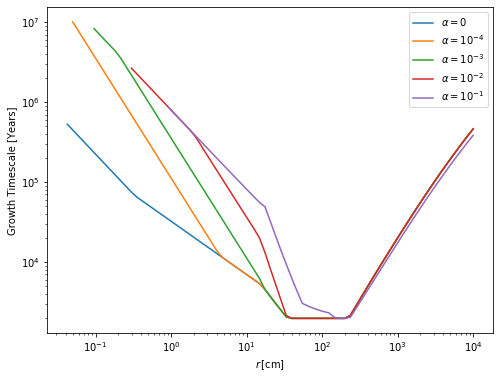

In [6]:
plt.figure(figsize=(8,6))
alpha_labs = ["0$","10^{-4}$","10^{-3}$","10^{-2}$","10^{-1}$"]

for i,alpha in enumerate(alpha_arr):
    plt.loglog(s_arr,zero_to_nan(times[i]),label=r'$\alpha = ' + alpha_labs[i])
    
plt.xlabel(r'$r \, [\mathrm{cm}]$')
plt.ylabel('Growth Timescale [Years]')

plt.gca().legend(loc='best')

#### If we wish to input particle Stokes number $St$ as opposed to particle radius, we can use the *st_solver* function to convert between Stokes number and radius. In this example we produce a colormap of the growth timescale as a function of both planet mass and particle Stokes number.

In [7]:
a_au = 1.
m_star = 1.
alpha = 1e-3

st_arr = np.logspace(-4,2,num=100)
M_arr = np.logspace(-4,2,num=100)

times = np.zeros((len(M_arr),len(st_arr)))


for i,M in enumerate(M_arr):
    for j,st in enumerate(st_arr):
              
        s = st_solver(st=st,alph=alpha,a_au=a_au,m_earths=M)
        
        core_tmp = Core(a_core_au=a_au,m_core_earthmasses=M,alpha=alpha,m_star_solarmasses=m_star,rho_core=2.)
        core_tmp.main(s=s)
        
        times[i,j] = core_tmp.t_acc

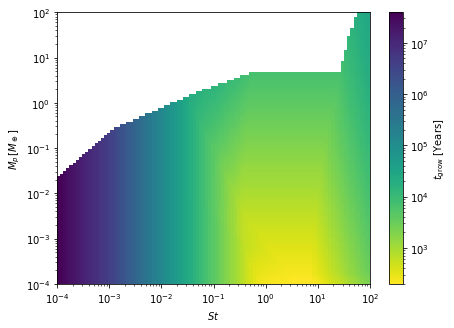

In [8]:
from matplotlib.colors import LogNorm

fig = plt.figure(figsize=(7,5))

X, Y = np.meshgrid(st_arr,M_arr)
cmap = 'viridis_r'
im = plt.pcolormesh(X,Y,times, cmap=cmap,norm=LogNorm())

plt.xscale('log')
plt.yscale('log')
cb = plt.colorbar(im,cmap=cmap,norm=LogNorm())

plt.xlabel(r'$St$')
plt.ylabel(r'$M_p \, \left[M_\oplus \right]$')
cb.set_label(r'$t_{\rm{grow}}$ [Years] ')

#### The code uses a defualt disk profile of \begin{align}
T(r) &= 200 \, \mathrm{K} \, \left( \frac{r}{\mathrm{au}} \right)^{-3/7}\\
\Sigma(r) &= 500 \, \mathrm{g} \, \mathrm{cm}^{-2} \, \left( \frac{r}{\mathrm{au}} \right)^{-1}
\end{align}

#### These defaults can be overridden using the *temp_in* and *sig_g_in* variables. For example, suppose we wanted the growth timescale as a function of distance for $M_\mathrm{p} = 10^{-1} M_\oplus$ and $St = 10^{-1}$, but for a disk surface density that followed the similarity solution for a viscous accretion disk from Lyden-Bell and Pringle (1974). 

In [57]:
a_au = 1.
m_star = 1.
alpha = 1e-3
r1 = 30
M = 1e-1
st = 1e-1

r_arr = np.logspace(-1,2.5,num=100)
Md = 0.015*fn.m_sun #Protoplanetary disk mass 

T = lambda r: 200*r**(-1/2) #Use a simpler semi-major axis scaling for T so that alpha viscosity scales as r^1
gamma = 1. #Power law exponent for viscosity
cs_0 = fn.sound_speed(T(1))
Omega_0 = fn.omega(m_star*fn.m_sun,fn.au)
nu = lambda r: alpha*cs_0**2/Omega_0*r**gamma #Shakura-Sunyaev alpha viscosity
t_visc = (r1*fn.au)**2./(3*(2-gamma)**2.)/nu(r1)

def sig_sim(r,t): #Similarity solution for a viscous disk from Lyden-Bell and Pringle (1974). Functional form taken from Hartmann et al (1998)
    R = r/r1
    
    T = t/t_visc + 1
    
    sim_sol = Md*(2-gamma)/(2*np.pi*(r1*fn.au)**2.)/(R**gamma)*T**((-5/2 - gamma)/(2 - gamma))*np.exp(-R**(2-gamma)/T)
    
    return sim_sol

In [58]:
disk_times = [0,t_visc/2,t_visc,2*t_visc]
growth_times = np.zeros((len(disk_times),len(r_arr)))
               
for i,t in enumerate(disk_times):
    for j,a_au in enumerate(r_arr):
        s = st_solver(st=st,alph=alpha,a_au=a_au,m_earths=M,temp_in=T(a_au),sig_g_in=sig_sim(a_au,t))

        core_tmp = Core(a_core_au=a_au,m_core_earthmasses=M,alpha=alpha,m_star_solarmasses=m_star,rho_core=2.,\
                       temp_in=T(a_au),sig_g_in=sig_sim(a_au,t))
        core_tmp.main(s=s)

        growth_times[i,j] = core_tmp.t_acc

Text(0.5, 0, 'Semi-major axis [au]')

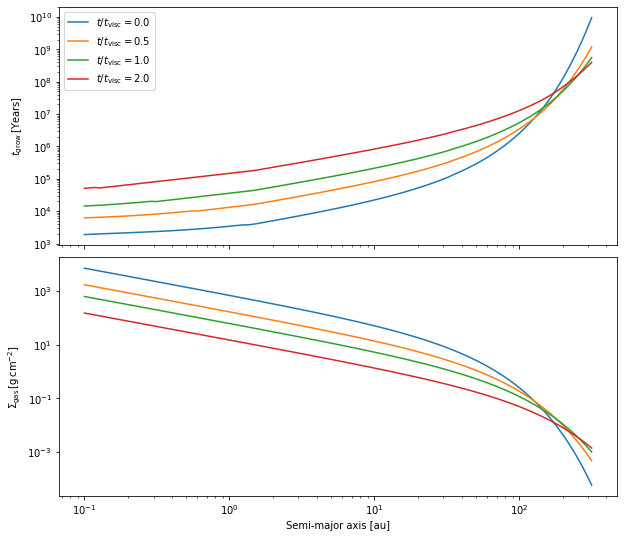

In [59]:
_, (ax1,ax2) = plt.subplots(2,1,figsize=(10,9),sharex=True,gridspec_kw={'hspace':0.05})

for i,t in enumerate(disk_times):
    ax1.loglog(r_arr,growth_times[i],label=r'$t/t_\mathrm{visc} = %.1f$' %(t/t_visc))
    ax2.loglog(r_arr,sig_sim(r_arr,t))
    
ax1.legend(loc='best')
ax1.set_ylabel(r'$t_\mathrm{grow} \, [\mathrm{Years}]$')
ax2.set_ylabel(r'$\Sigma_\mathrm{gas} \, [\mathrm{g} \, \mathrm{cm}^{-2}]$')
ax2.set_xlabel("Semi-major axis [au]")